In [1]:
# connect Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# check Nvidia GPU model
!nvidia-smi

Mon Nov 22 08:26:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# install dependencies
!pip install --upgrade transformers
!pip install anyascii
!pip install contractions

In [4]:
# import all required modules
import pandas as pd
import re
import seaborn as sns
import string
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification
import numpy as np
from sklearn import model_selection
from keras import layers
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import os
import tensorflow as tf
import math
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from anyascii import anyascii
from contractions import fix

import re
import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
# define file path from Google Drive
path = 'drive/My Drive/twitter.csv'
df = pd.read_csv(path)
df.head()  # check first 5 rows


,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,NaN
1,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
2,2,NaN,NaN,"Heard about #earthquake is different cities, s...",NaN
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",NaN
4,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0


# Set which bert model to be used along with Tokenizer

In [6]:
bert_model = "bert-large-uncased"  # the Bert pre-trained model to use (base or large)

tokenizer = BertTokenizer.from_pretrained(bert_model, num_labels=2)  # define the Tokenizer to be used

bert = TFBertModel.from_pretrained(bert_model, num_labels=2)  # The bert model to be used

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:
print("max len of tweet", max([len(x.split()) for x in df.text])) # check max len of a tweet from data

max len of tweet 31


In [8]:
df_c = df.copy()
df_c=df_c.drop(columns=['keyword','id', 'location'])  # drop unrequired columns
df_c=df_c.dropna()  # drop NA rows

# Clean up data

In [9]:
df_c.text=df_c.text.apply(lambda x:x.lower())  # conver to lower case

#removing square brackets
df_c.text=df_c.text.apply(lambda x:re.sub('\[.*?\]', '', x) )
df_c.text=df_c.text.apply(lambda x:re.sub('<.*?>+', '', x) )

#removing hyperlink
df_c.text=df_c.text.apply(lambda x:re.sub('https?://\S+|www\.\S+', '', x) )

#removing puncuation
# df_c.text=df_c.text.apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), '', x) )
# df_c.text=df_c.text.apply(lambda x:re.sub('\n' , '', x) )

#remove words containing numbers
df_c.text=df_c.text.apply(lambda x:re.sub('\w*\d\w*' , '', x) )

# replace greater/less than symbols
df_c.text = df_c.text.apply(lambda x: re.sub(r"&gt;", ">", x))
df_c.text = df_c.text.apply(lambda x: re.sub(r"&lt;", "<", x))
df_c.text = df_c.text.apply(lambda x: re.sub(r"&amp;", "&", x))

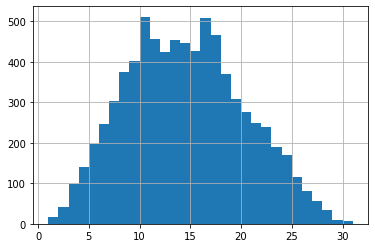

In [10]:
# create hstogram for tweet lengths
raw_length = [len(i.split()) for i in df_c['text']]

pd.Series(raw_length).hist(bins = 30)

In [11]:
# split data into TRain and Test values via SKLearn utility
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df_c['text'],df_c['target'], test_size=0.15)

# Set input tokenizers

In [12]:
 # convert labels into categorical types for 2 classes available (disaster and non-disaster tweets)
 train_label = keras.utils.to_categorical(Train_Y, num_classes=2).astype('int64')
 test_label = keras.utils.to_categorical(Test_Y, num_classes=2).astype('int64')
 
 # define train and val tokenized input data
 x_1= tokenizer(
    text=Train_X.to_list(),
    add_special_tokens=True, #only in this case
    max_length=31,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

y_1=train_label

x_2= tokenizer(
    text=Test_X.to_list(),
    add_special_tokens=True, #only in this case
    max_length=31,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

y_2=test_label

In [13]:
x_1['attention_mask'].shape

TensorShape([6471, 31])

In [14]:
train_label.shape

(6471, 2)

# Define entire model

### Bert model output used with custom NN

In [15]:
max_len = 31 # variable to hold max-len value

# define the entire model along with Bert output and custom ANN
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")

input_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[1] 

out = tf.keras.layers.Dropout(0.2)(embeddings)

out = layers.Dense(1024, activation='relu')(out)  # 1024 as output of pooled layer from bert-large is 1024 in size

out = tf.keras.layers.Dropout(0.2)(out)  # dropout used to reduce over-fitting to some extent

out = layers.Dense(256, activation='relu')(out)

out = tf.keras.layers.Dropout(0.1)(out)

out = layers.Dense(16, activation='relu')(out)

out = layers.Dense(2, activation = None)(out)

y = layers.Softmax(axis=-1)(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

model.summary()  # check model layout and layers via summary along with total trainable params

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 31)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 31)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 31,                                            

In [16]:
model.layers

In [17]:
model.layers[2].trainable = True # index 2 in Model layers is the bert model, which we have fine-tuned for few epochs with additional ANN

# Define optimizer, loss, metric and compile model

In [18]:
initial_lr = 8e-6

# define Optimizer to be used to update weights after backprop
optimizer = keras.optimizers.Adam(
    learning_rate=initial_lr,
    decay=0.01,
    clipnorm=1.0)  # have used clipnorm to apply Gradient Clipping to avoid large gradients from ruining pre-trained model much from large updates

# Set loss and metric to be used
loss = keras.losses.BinaryCrossentropy(from_logits = False)

metric = keras.metrics.BinaryAccuracy('accuracy')

# Compile the model with optimizer and loss to be used
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)


# Learning rate schedules

![](https://miro.medium.com/max/2000/1*6Zr7nkI97IGT9e_tpgK-_g.png)

Learning Rate Schedules seek to adjust the learning rate during training by reducing the learning rate according to a pre-defined schedule. The popular learning rate schedules include
#### 1. Constant learning rate
----

#### 2. Time-based decay
![](https://miro.medium.com/max/1400/1*zyQulWm4KRkiWtL_e5Mnyg.png)
----

#### 3. Step decay
![](https://miro.medium.com/max/1400/1*5N95STd9deaYati3Cn4o6g.png)
----
#### 4. Exponential decay
![](https://miro.medium.com/max/1400/1*CgioTtU7G7mL202dL7CVfg.png)

In [19]:
initial_learning_rate = initial_lr
epochs = 20

# calcualte decay rate based on total epochs and initial LR
decay = initial_learning_rate / epochs

# Time based learning weight decay
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

# Exponential learning rate decay
def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

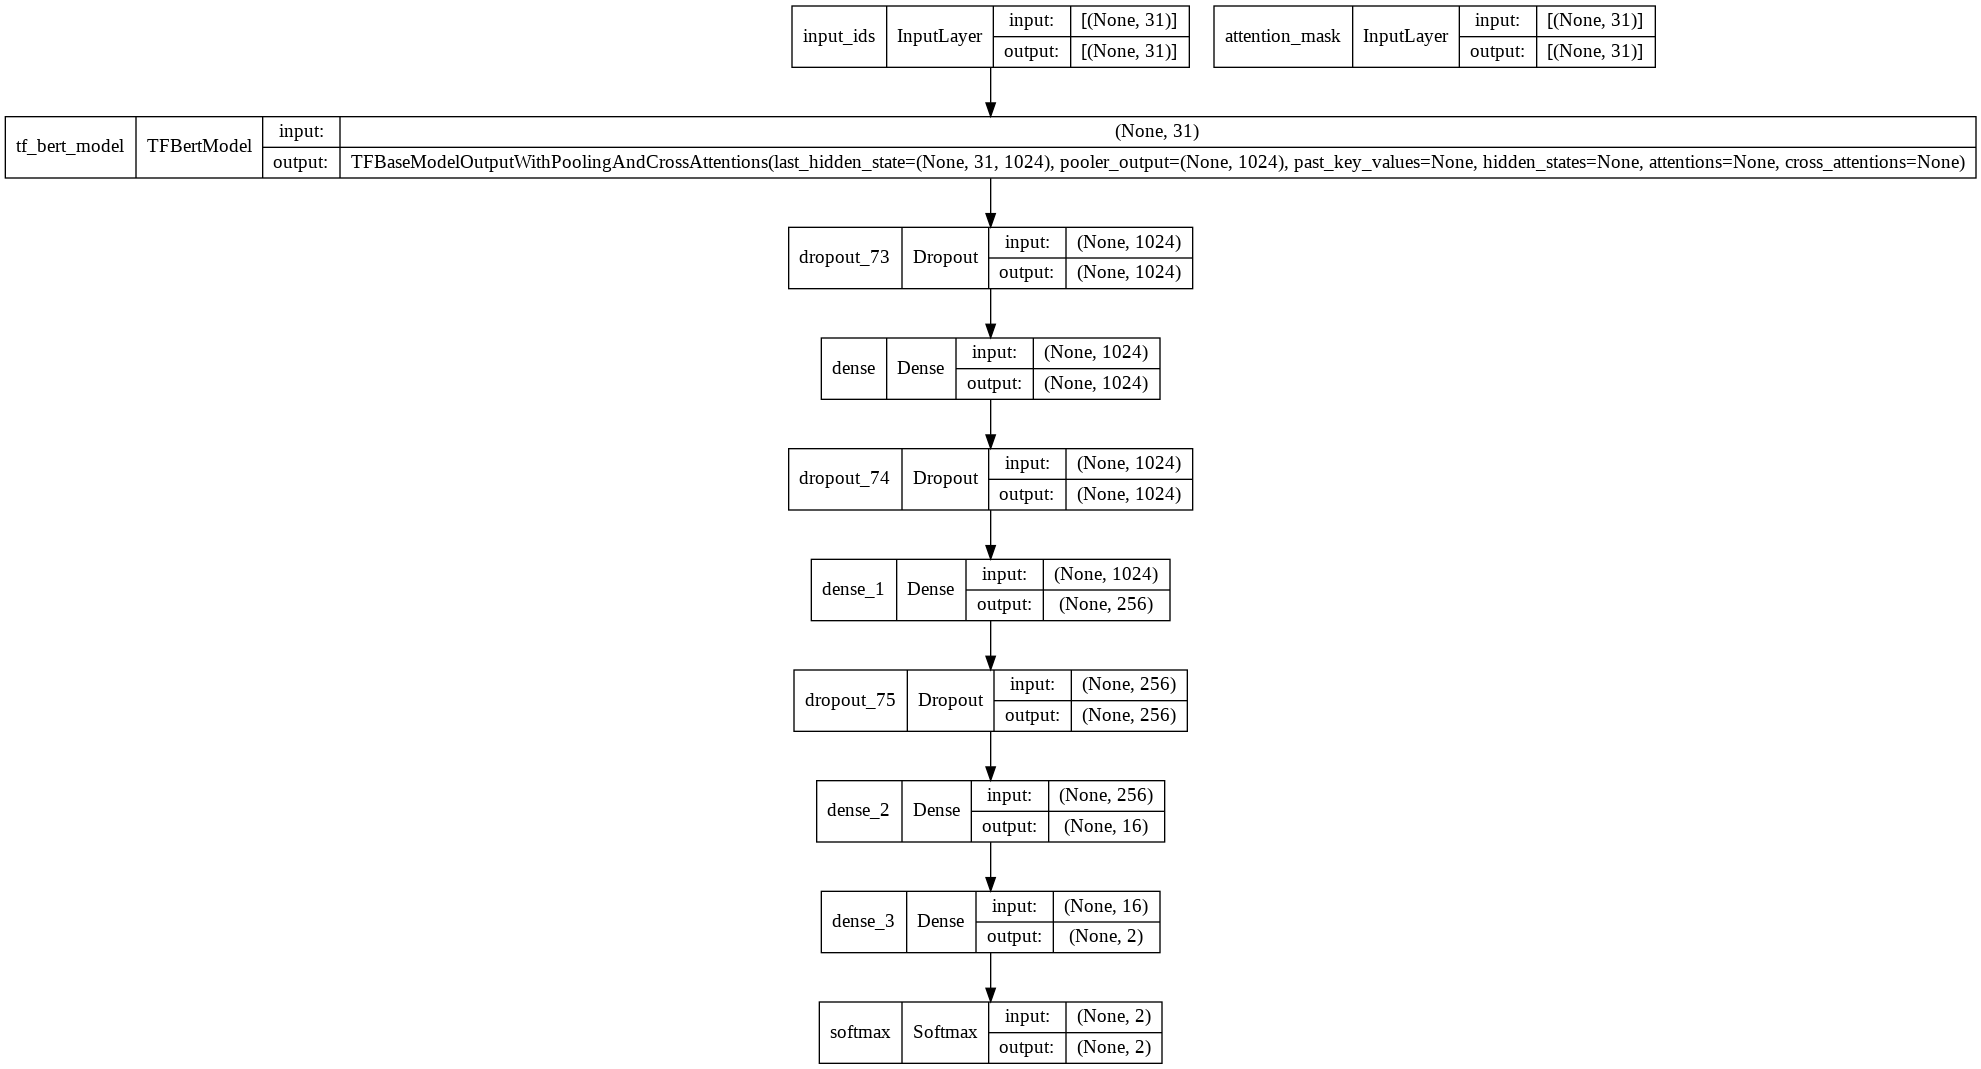

In [20]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)  # plot model layers in pictorial form

# Model save checkpoint callback

In [21]:
# To save improved trained model after checking Validation accuracy improvement at each epoch
checkpoint_filepath = '/tmp/checkpoint'

# we will monitor 'val-accuracy', we want to save model if val-acc. increases and want to save entire model and not just trained weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Train model

In [22]:
# Train the model using train and validation data, with callbacks for ModelCheckPoint as well as Learning Rate Scheduler, for `epochs` epochs
train_history = model.fit(
    x ={'input_ids':x_1['input_ids'],'attention_mask':x_1['attention_mask']},
    y = y_1,
    epochs=epochs,
    batch_size=64,
    callbacks=[model_checkpoint_callback, tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)],
    validation_data=({'input_ids':x_2['input_ids'],'attention_mask':x_2['attention_mask']}, y_2)
)


Epoch 00001: LearningRateScheduler setting learning rate to 8e-06.
Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.6523

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


102/102 [==============================] - 328s 3s/step - loss: 0.6384 - accuracy: 0.6523 - val_loss: 0.5085 - val_accuracy: 0.7636 - lr: 8.0000e-06

Epoch 00002: LearningRateScheduler setting learning rate to 7.238699344287676e-06.
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.7847

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


102/102 [==============================] - 262s 3s/step - loss: 0.4864 - accuracy: 0.7847 - val_loss: 0.4598 - val_accuracy: 0.8012 - lr: 7.2387e-06

Epoch 00003: LearningRateScheduler setting learning rate to 6.549846024623855e-06.
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 0.4303 - accuracy: 0.8210

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


102/102 [==============================] - 262s 3s/step - loss: 0.4303 - accuracy: 0.8210 - val_loss: 0.4367 - val_accuracy: 0.8214 - lr: 6.5498e-06

Epoch 00004: LearningRateScheduler setting learning rate to 5.926545765453743e-06.
Epoch 4/20
102/102 [==============================] - 90s 881ms/step - loss: 0.4068 - accuracy: 0.8343 - val_loss: 0.4363 - val_accuracy: 0.8205 - lr: 5.9265e-06

Epoch 00005: LearningRateScheduler setting learning rate to 5.362560368285114e-06.
Epoch 5/20
102/102 [==============================] - 90s 880ms/step - loss: 0.3935 - accuracy: 0.8388 - val_loss: 0.4333 - val_accuracy: 0.8170 - lr: 5.3626e-06

Epoch 00006: LearningRateScheduler setting learning rate to 4.852245277701067e-06.
Epoch 6/20
102/102 [==============================] - ETA: 0s - loss: 0.3847 - accuracy: 0.8408

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


102/102 [==============================] - 262s 3s/step - loss: 0.3847 - accuracy: 0.8408 - val_loss: 0.4292 - val_accuracy: 0.8249 - lr: 4.8522e-06

Epoch 00007: LearningRateScheduler setting learning rate to 4.390493088752211e-06.
Epoch 7/20
102/102 [==============================] - ETA: 0s - loss: 0.3780 - accuracy: 0.8476

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


102/102 [==============================] - 263s 3s/step - loss: 0.3780 - accuracy: 0.8476 - val_loss: 0.4265 - val_accuracy: 0.8275 - lr: 4.3905e-06

Epoch 00008: LearningRateScheduler setting learning rate to 3.9726824303312755e-06.
Epoch 8/20
102/102 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8513

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


102/102 [==============================] - 326s 3s/step - loss: 0.3647 - accuracy: 0.8513 - val_loss: 0.4234 - val_accuracy: 0.8319 - lr: 3.9727e-06

Epoch 00009: LearningRateScheduler setting learning rate to 3.5946317129377723e-06.
Epoch 9/20
102/102 [==============================] - 90s 881ms/step - loss: 0.3695 - accuracy: 0.8509 - val_loss: 0.4237 - val_accuracy: 0.8301 - lr: 3.5946e-06

Epoch 00010: LearningRateScheduler setting learning rate to 3.2525572779247926e-06.
Epoch 10/20
102/102 [==============================] - 90s 880ms/step - loss: 0.3628 - accuracy: 0.8544 - val_loss: 0.4258 - val_accuracy: 0.8266 - lr: 3.2526e-06

Epoch 00011: LearningRateScheduler setting learning rate to 2.9430355293715384e-06.
Epoch 11/20
102/102 [==============================] - 90s 880ms/step - loss: 0.3609 - accuracy: 0.8547 - val_loss: 0.4231 - val_accuracy: 0.8292 - lr: 2.9430e-06

Epoch 00012: LearningRateScheduler setting learning rate to 2.6629686695846365e-06.
Epoch 12/20
102/102 [==

# Plot loss and accuracy

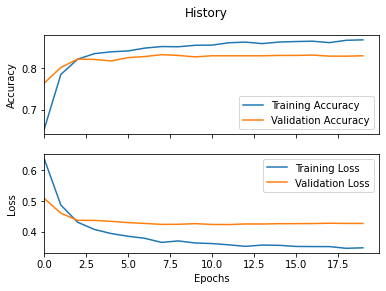

In [24]:
# Get the loss and accuracy metrics for plotting
train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
train_acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

# Plot the training and validation metrics
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
sns.lineplot(ax=ax1, data = train_acc, label=f'Training Accuracy')
sns.lineplot(ax=ax1, data = val_acc, label=f'Validation Accuracy')
sns.lineplot(ax=ax2, data = train_loss, label=f'Training Loss')
sns.lineplot(ax=ax2, data = val_loss, label=f'Validation Loss')
ax1.set_ylabel('Accuracy')
ax1.set_xlim(xmin=0)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_xlim(xmin=0)
plt.suptitle('History')
plt.show()

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = model.predict({'input_ids':x_2['input_ids'],'attention_mask':x_2['attention_mask']})
print("Accuracy:", accuracy_score(y_2, y_pred.round())) # Value between 0 and 1
preds = np.argmax(y_pred, axis = 1)
print(classification_report(np.argmax(y_2, axis = 1), preds))
print(confusion_matrix(np.argmax(y_2, axis = 1), preds))

Accuracy: 0.829246935201401
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       661
           1       0.85      0.73      0.78       481

    accuracy                           0.83      1142
   macro avg       0.83      0.82      0.82      1142
weighted avg       0.83      0.83      0.83      1142

[[597  64]
 [131 350]]
